# Back into Jupyter
Mandelbrot set nonsense for funzies.
**Goals**:
- [x] Estimate area using funky statistical methods.
- [ ] Lemniscate graphing and approaching the border
- [ ] Compute complexity for a given region
- [ ] Hausdorff-dimension approximations

## Introduction.
Random graph ideas to remind me of Matplotlib & the Python user experience.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 82 ms


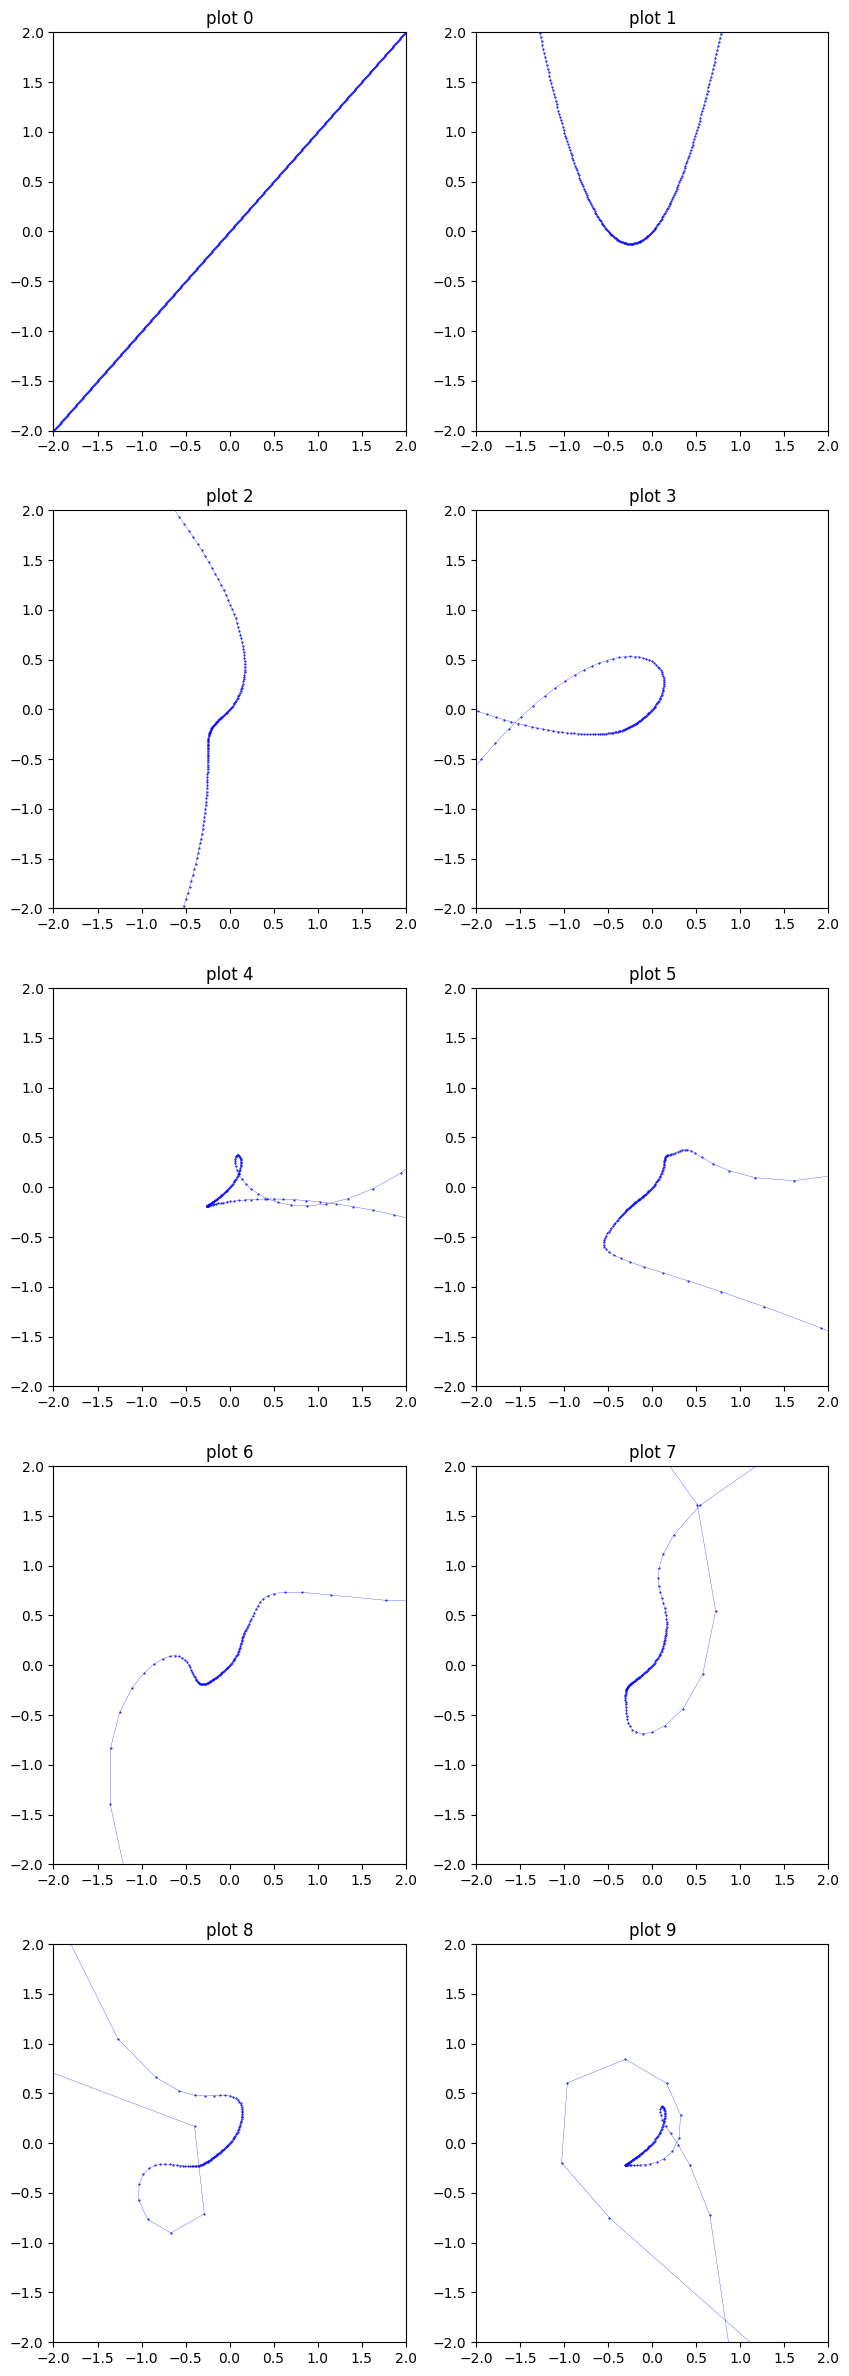

In [3]:
%%time

import numpy as np
from matplotlib import pyplot as plt

density = 400

zlist = []
xlist = np.linspace(-2, 2, density)
ylist = np.linspace(-2, 2, density)
zlist = xlist + ylist*1j

def fx(z, c):
    return (z**2) + c

fig, ax = plt.subplots(5, 2, figsize = (10, 30))
for array in ax:
    for obj in array:
        obj.set(xlim = (-2,2), ylim = (-2,2))

maxit = 10
zlist2 = zlist[:]
i = 0
for array in ax:
    for obj in array:
        obj.set_title(f'plot {i}')
        obj.plot(np.real(zlist2), np.imag(zlist2),
             marker = 'o',
             markersize = 0.5,
             linewidth = 0.2,
             color = 'blue',
            )
        zlist2 = fx(zlist2, zlist)
        i = i + 1

## Statistical methods for estimating the area of the Mandelbrot set. 

Practically guaranteed to be useless estimates. The goal window is $A_\mathcal{M} \in [1.5, 1.7] \subset \mathbb R$.

If we land somewhere in $\mathbb R$ it'll be a good start, compared to last time ... 

#### Method 1. Random Guessing.

Lets first try uniform distribution, then jump to something more clever after we get a working prototype. 

Geoemetrically, I hypothesize on getting abysmal results since $\delta \mathcal M = 2$ (according to [Shishikura](https://www.jstor.org/stable/121009?origin=crossref)). This means that despite these methods *technically* working, I imagine that eons will pass before we get anything close to the actual area of the Mandelbrot set. 

The idea is to start simple, where a random variable that's uniformly distributed across a region has a probability of occuring in the Mandelbrot set equal to the ratio of $\mathcal M$'s area to the region. Then if the region contains $\mathcal M$, the area is strictly determininstic. 

From there, we'll branch into letting regression sink into the edges of the Mandelbrot set. I've got some plans that could help imrpove the rates of approaching the actual area for later. This could make for an interesting machine learning model, since everything is deterministic -- a nice playground to learn about data science.

In [2]:
# function definitions

import numpy as np
from matplotlib import pyplot as plt

def f(c, z = 0): ## mandelbrot set func
    return z**2 + c

## t/f test for value being in the mandelbrot set
def is_Mandel(val, MAXIT = 100):
    current = 0
    for k in range (0,MAXIT):
        current = f(val, current)
        if np.abs(current) > 2:
            return 0 ## 0 == false
    else: return 1   ## 1 == true

Matplotlib is building the font cache; this may take a moment.


In [56]:
## choosing in a rectangle is guaranteed to be uniform (thanks stats class)
def unifRectCmp(n = 2, m = 2):
    return ( 2*n * np.random.rand() - n ) + ( 2*m * np.random.rand() - m ) *1j

## original idea as a function. So that we can iterate and see the total altogether (convergence rate testing)
def areaGuessPlotter(random_guesses = 20, rect_length = 2, rect_height = 2, ax = None):
    zstack = np.empty(random_guesses).astype(complex) ## make sure array is complex type
    for i in range(0, random_guesses):
        zstack[i] = unifRectCmp(rect_length, rect_height)
    
    ## evaluate each as boolean (bernoulli y = 'in mandel', n = 'not in mandel)
    bstack = np.empty(random_guesses).astype(complex)
    for i in range(0, random_guesses):
        if is_Mandel(zstack[i]):
            bstack[i] = True
        else:
            bstack[i] = False
    
    ## plot setup
    if ax == None:
        fig, ax = plt.subplots()
    ax.set_aspect(1)
    ax.set_axis_off()
    
    ## horrible solution but works for small sizes for now. 
    ## needs to be optimized to seriously increase speed
    ##  could: reduce plot commands, split trues/falses then plot each once as vector
    count = 0
    for i in range(0, random_guesses):
        if bstack[i] == 1:
            col = 'blue' ## in mandel
            count += 1
        else:
            col = 'red' 
        ax.plot(
            np.real(zstack[i]), np.imag(zstack[i]),
            marker = 's',
            markersize = 1,
            linewidth = 0,
            color = col
        )
    
    ## calculate mandelbrot area
    area_guess = 4*rect_length*rect_height * count/random_guesses
    ax.set_title(np.round(area_guess, 3))
    return ax, area_guess

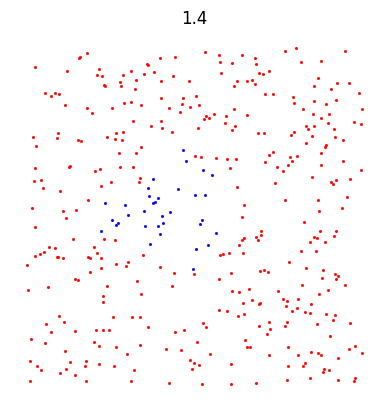

In [54]:
areaGuessPlotter(400, 2, 2)
plt.show()

**Notes.** After working through it, we got some great answers. $1.33, \ 1.45$ is honestly better than I expected. We know this answer to be somewhere between 1.5 and 1.7 according to some random email chain I found, and I don't doubt it. Maybe we should do some more serious mathematics bounding the area, but what's the fun in that? Let's see if the computer can use this information to see how quickly we get convergence for a variety of values. 

**Questions that have arisen.**
* **Shouldn't we be equally likely to overshoot as undershoot?** This doesn't appear true. We seem way more likely to *seriously* undershoot. It behaves like I would expect bias to. But how can geometric area be biased?

average 1.5463046707783719
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.79 s


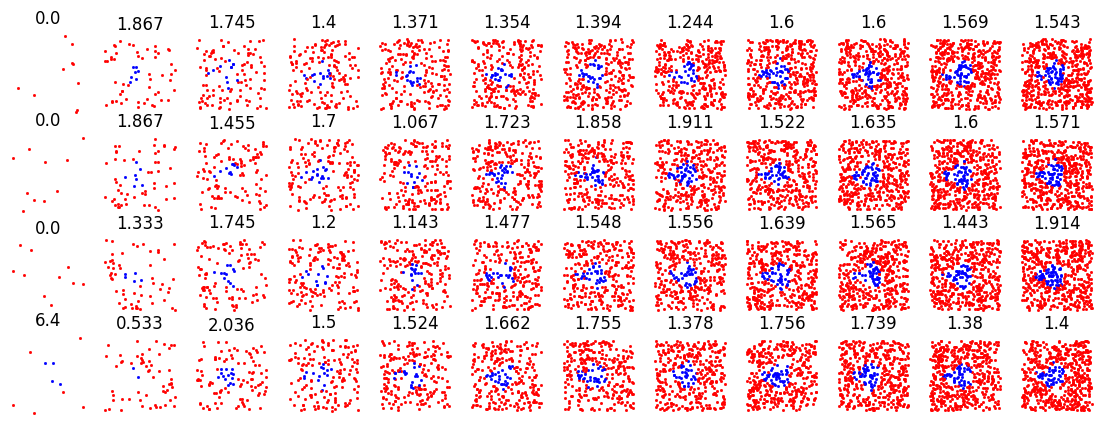

In [57]:
%%time

num_rows = 4
num_cols = 12

## make a 2d plotting array. rows increase trials, cols increase num choices
fig, ax = plt.subplots(num_rows, num_cols, figsize = (num_cols + 2, num_rows + 1))

area_stack = np.zeros((num_rows, num_cols))
for rownum in range(0, num_rows):
    i = 0
    for colnum in range(0, num_cols):
        ax[rownum][colnum], area_stack[rownum][colnum] = areaGuessPlotter(10 + i*50, 2, 2, ax[rownum][colnum])
        i = i + 1
print(f"average {np.average(area_stack)}")

Appears more effective than I thought. I'd like to see if the sample variance is lowering with increased sampling, but I want the sampling to stay consistent between trails. I'll accomplish this by using a giant array. Good reminders of classes in Python.

I'm using randomness for fun, but the looming thoughts of increased accuracy by simply defining a grid of pixels and computing using that is *so appealing*. I'll stick to random for now. While uniformly sampling points sucks, the Mandelbrot set's presumed local connectivity could give me some ways to use random sampling as an advantage later. 

In [61]:
%%time

depth = 10   ## 
trials = 4   ## to compare
steps = 30   ## increase per depth 

frame = np.zeros((depth, trials, 2)).astype(complex)


[[[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2 ms
